# RA2CE feature: Origin-destination analysis

This notebook contains an example of the **origin-destination analysis** of the RA2CE model. This notebook should be used in combination with the predefined data. A user could create their own examples, using the RA2CE functionality of their interest. This requires the right folder setup, and the correct settings in the configuration files (network.ini and analyses.ini).

In this notebook, we will guide you through the origin-destination analysis as if it were used in an emergency response setting.

First of all, we will import the packages we need to execute the notebook:

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import rasterio

Then, we have to set some basic variables. Keep in mind that you will have to specify the path to your local machine yourself.
First, we will set the path to the ra2ce folder and we will initialize the names for the network and analysis ini files.

Afterwards, let's find the examples folder on your machine.

In [ ]:
from ra2ce.ra2ce_handler import Ra2ceHandler #import the ra2cehandler to run ra2ce analyses

## Origin closest destination analyses

Origin-Destination (OD) analyses aim to determine the most optimal route, either based on distance or time, from specified Origins to Destinations. The RA2CE OD-analysis enables users to analyze various combinations of Origins and Destinations based on their specific research interests.

For instance, you can calculate the optimal routes from residential homes to hospitals, or from residential homes to schools. Alternatively, you can find the optimal route from schools to hospitals. The possibilities for analysis vary depending on the particular question you wish to explore.

### Emergency response example

This example aims to show how emergency responders could use RA2CE to respond to a flood event, in Beira. 
Emergency responders can for example be interested in which roads are flooded in the area. They might also be interested in gaining insights into the locations of the residential areas impacted by the event and accessible routes to hospitals or locations that will function as shelters during a part of the recovery phase.<br>
<br>

With these RA2CE analyses, it is for example possible to create analyses like the one below in Sint Maarten:

*Note that these images were generating using QGIS*

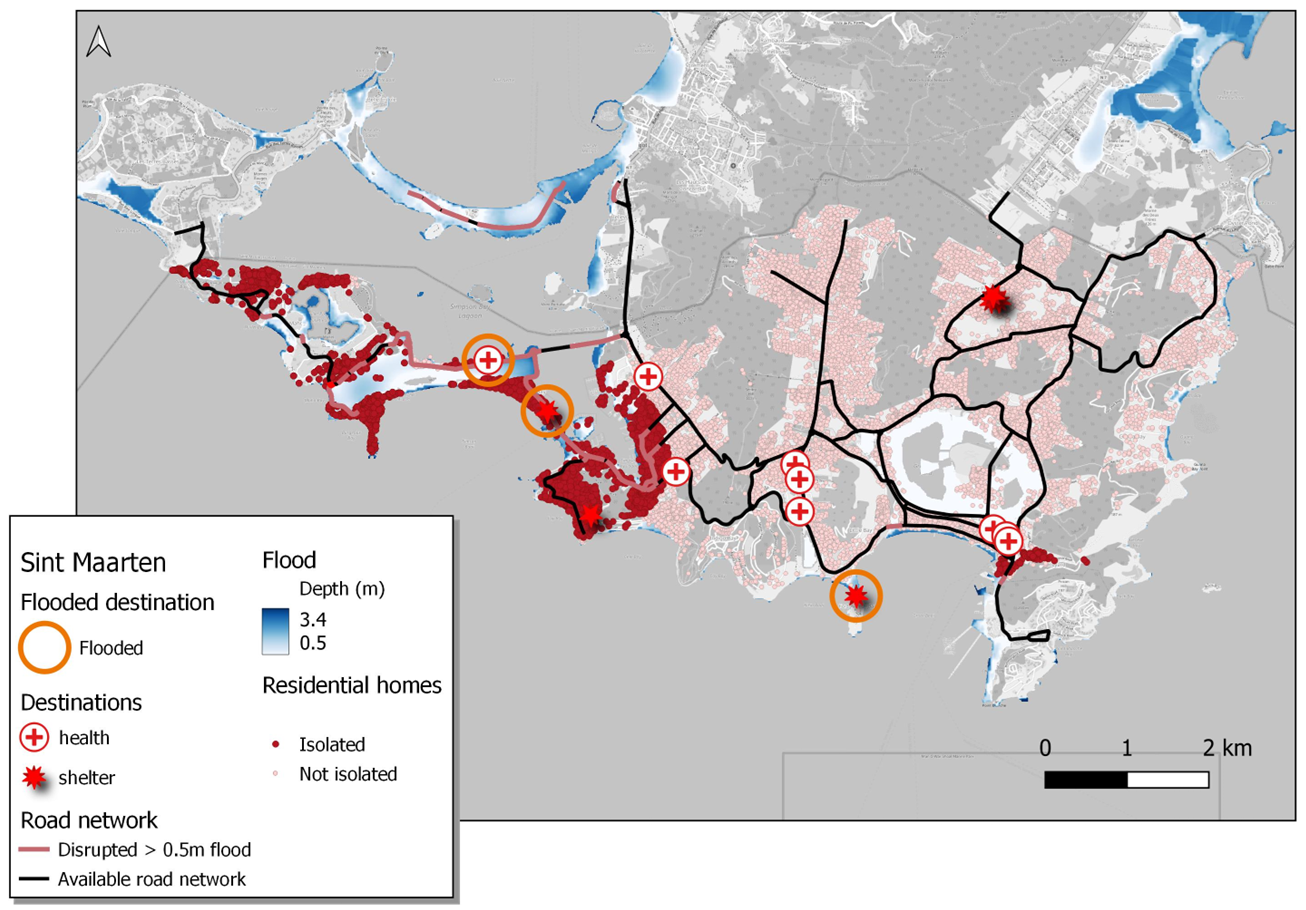

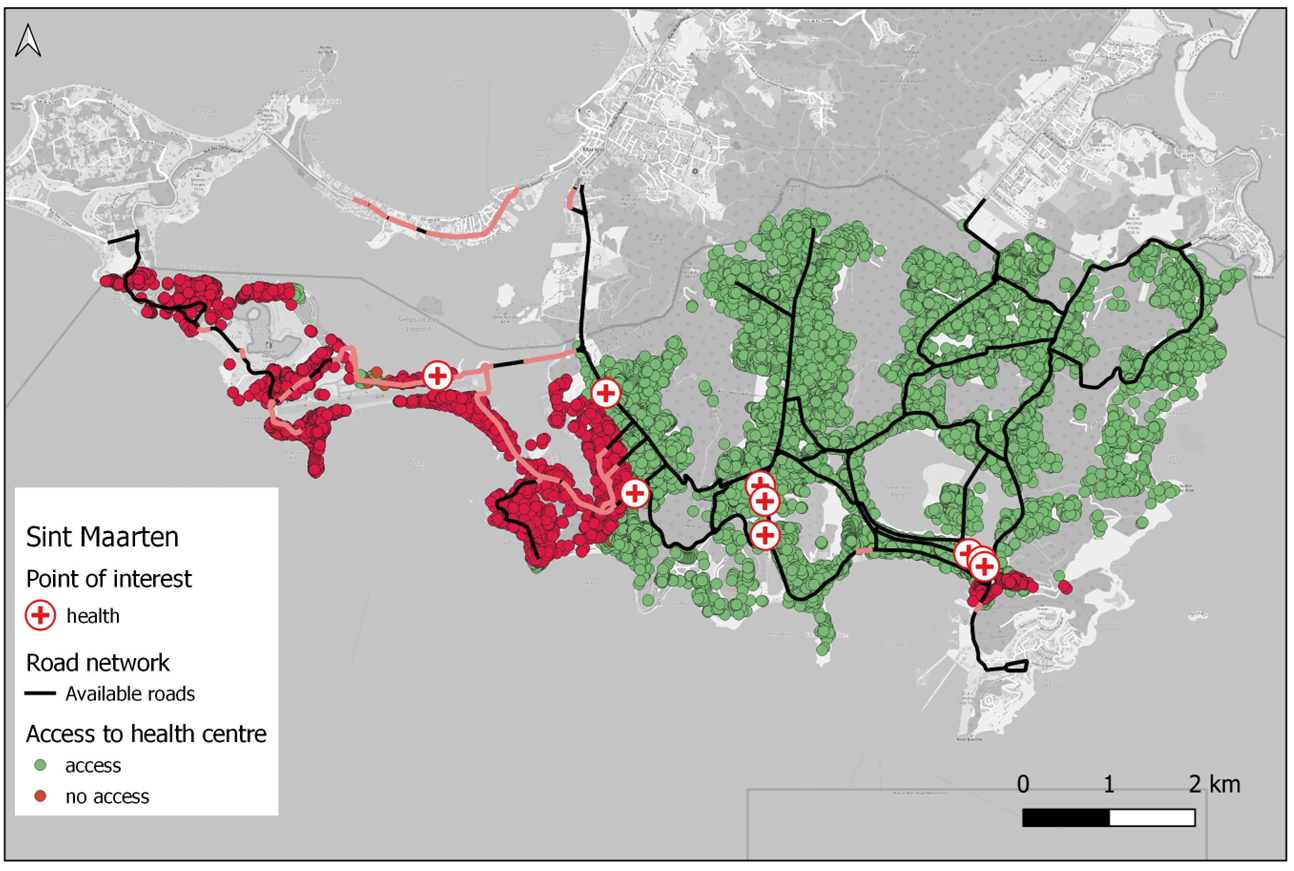

## Origin closest destination without hazard

Firstly, define the folder in which the data exist:

In [ ]:
# specify the path to the folder holding the RA2CE folder and input data
root_dir = Path(__file__).parent.joinpath("data", "origin_destination_analysis_without_hazard")

### Creating origins and destinations data

For origins, we want to know how many people live where. To estimate this, we make use of the global WorldPop database. This can be used as origin points, after a manual raster to point conversion in QGIS (this was already done). Bear in mind that the origin data needs to be of a specific type (point shapefile/gpkg) and have a specific structure: it should hold an **ID-column** and there should be a field with the **origin_counts** (these can also be 0). The **origin_counts** attribute can hold any numeric value which will be used to count how many *units* (in this example, people) use a certain road segment to reach its destination, and per destination how many units can reach that destination.

The same goes for the destinations. The destinations also needs to be a point shapefile/gpkg and needs an **ID-column**. It does not require an origin count column, however, destinations need a **category** column in which you specify the category of a destination (e.g., hospital, supermarket). For this example, we have used OpenStreetMaps (OSM) to derive the destination data.

The CRS of both origin and destination files is required to be in **WGS84** EPSG:4326.

After creating this data, the user needs to save the data in the **static/network** folder. 

Below, we first introduce the origins generated from WorldPop. These hold locations of residents and the number of residents in each point (generated from a grid).

In [ ]:
origins_inspection = root_dir/"static"/"network"/"origins.shp"
origins_gdf = gpd.read_file(origins_inspection, driver = "SHP")
origins_gdf.head()
origins_gdf.explore(column = "POPULATION", cmap = "viridis_r", tiles="CartoDB dark_matter")

In this example, we look at the accessibility from residential homes to educational institutes and hospitals during the flood. We have created a layer of these points as destinations using the openOSM plugin in QGIS. You can inspect these files in QGIS. We will also load them here:

In [ ]:
destinations_inspection = root_dir/"static"/"network"/"destinations.shp"
destinations_gdf = gpd.read_file(destinations_inspection, driver = "SHP")
destinations_gdf.explore(column = "category", cmap = ['Blue', 'Green'], tiles="CartoDB dark_matter")

Check whether the necessary attributes and values are in your files:

*Note: Make sure your geometry is point and not multipoint.*

In [ ]:
origins_gdf.head()

In [ ]:
destinations_gdf.head()

### Specifying the .ini files

Now, to tell RA2CE how to use the origins and destinations, the user needs to specify the file names in the network.ini.

*Notice how you can keep the [network] parameters the same as in the RA2CE Basics example. RA2CE will automatically use the graph you have already created. Or, if you want to create a new graph, it can run both processes consecutively.*

**Network.ini content**
<br>
<br>
> [project]<br>
name = beira<br>
<br>
[network]<br>
**directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = region_polygon.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential<br>
save_gpkg = True**<br>
<br>
[origins_destinations]<br>
**origins = origins.shp<br>
destinations = destinations.shp<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID<br>
origin_count = POPULATION<br>
origin_out_fraction = 1<br>
category = category**<br>
<br>
*[hazard]<br>
hazard_map = None<br>
hazard_id = None<br>
hazard_field_name = None<br>
aggregate_wl = None<br>
hazard_crs = None<br>
<br>
[cleanup]<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = True<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*

We now need to update our analysis initialisation files using the preferred OD-analysis (there are multiple). For now we will consider the **optimal_route_origin_closest_destination** analysis. This analysis finds from each origin location, the closest destination per category. Another analysis that RA2CE offers is an OD analysis which tries to find routes from all origins to all destinations, but we won't run that one in this example. All types of losses analyses can be found [here](https://deltares.github.io/ra2ce/analysis_module/analysis_module.html#indirect-losses-network-criticality).

Navigate to the folder on your local machine with which you want to perform the analysis, and change the analysis.ini accordingly. Weighing defines the criterium based on which the optimal routes will be defined. It accepts *time* as well.

**Analysis.ini content**
<br>
<br>
> [project] <br>
name = beira <br>
<br>
[analysis1]<br>
name = multilink origin closest destination without hazard<br>
analysis = multi_link_origin_closest_destination<br>
aggregate_wl = None<br>
threshold = None<br>
weighing = distance<br>
calculate_route_without_disruption = True<br>
save_gpkg = True<br>
save_csv = True<br>
<br>

Set the paths to the initialization files and check if the files exist.

In [ ]:

_network_ini_name = "network.ini" #set the name for the network.ini
_analysis_ini_name = "analysis.ini" #set the name for the analysis.ini

network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

Run RA2CE. Notice the information RA2CE gives you. Education locations are referred to as D1 (destination 1) and hospital locations as D2 (destination 2).

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

## Origin closest destination with hazard

Firstly, define the folder in which the data exist:

In [ ]:
# specify the path to the folder holding the RA2CE folder and input data
root_dir = Path("data", "origin_destination_analysis_with_hazard")

Secondly, we need a flood map! We have an example flood map in our example folder. Let's inspect it.

*Note: the flood map needs to be in **.tif** format*

In [ ]:
hazard_folder = root_dir / "static" / "hazard" # find the hazard folder where you locate your floo dmap
hazard_map = hazard_folder / "max_flood_depth.tif" # set the location of the hazard map

# Open the TIF file using rasterio
with rasterio.open(hazard_map) as src:
    # Read the TIF file as a numpy array
    tif_array = src.read(1)  # Change the band index (1) if necessary

plt.figure(figsize=(10, 10))
plt.imshow(tif_array, cmap='Blues')  # Change the colormap if desired
plt.colorbar(label='Pixel Values')
plt.title('Flood map')
plt.show()


To use the flood map with RA2CE, we need to fill in the **[hazard]** section in the network.ini. 

Specify the flood map name in the **hazard_map** parameter in network.ini. RA2CE expects the flood map to be located in the *hazard* folder. The **aggregate_wl** parameter in analysis.ini can be set to either 'max', 'min' or 'mean' to take the maximum, minimum or mean water depth per road segment when the exposure of the roads to a certain hazard (map) is determined.<br>

Set the right CRS for the flood map in the **hazard_crs** parameter. This CRS can be different from the origins, destinations and road network. RA2CE will reproject the network to the CRS of the flood map and will reproject the road back to the original CRS when the CRS differs.

You can run a RA2CE analysis with only the hazard overlay on the roads. The results can be found in the output_graph folder. The data with *'\*_hazard'*, contains the result of the overlay with the hazard. Here, we will load the data from the example graph folder. 

*If you want to practice with this, create a new project folder where you specify the hazard map and perform the hazard analysis with RA2CE*

Notice the column **EV1_ma**. This refers to the hazard. This column holds the water depth of the road segment. 'EV1' stands for 'Event 1' (you can run multiple flood maps, the column results will be called EV1, EV2, EV3, etc.). '_ma' refers to maximum flood depth, which is the parameter specified in the network.ini. We always use the maximum water depth for the OD analysis because a vehicle can only use a road segment when it can drive through the largest water depth on that road segment.

### Specifying the .ini files

Now, to tell RA2CE how to use the origins and destinations, the user needs to specify the file names in the network.ini.

*Notice how you can keep the [network] parameters the same as in the RA2CE Basics example. RA2CE will automatically use the graph you have already created. Or, if you want to create a new graph, it can run both processes consecutively.*

**Network.ini content**
<br>
<br>
> [project]<br>
name = beira<br>
<br>
[network]<br>
**directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = region_polygon.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential<br>
save_gpkg = True**<br>
<br>
[origins_destinations]<br>
**origins = origins.shp<br>
destinations = destinations.shp<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID<br>
origin_count = POPULATION<br>
origin_out_fraction = 1<br>
category = category**<br>
<br>
[hazard]<br>
**hazard_map = max_flood_depth.tif<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
aggregate_wl = max<br>
hazard_crs = EPSG:32736**<br>
<br>
*[cleanup]<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = True<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*

We now need to update our analysis initialisation files using the preferred OD-analysis (there are multiple). For now we will consider the **optimal_route_origin_closest_destination** analysis. This analysis finds from each origin location, the closest accessible non-flooded destination per category. Another analysis that RA2CE offers is an OD analysis which tries to find routes from all origins to all destinations, but we won't run that one in this example. All types of losses analyses can be found [here](https://deltares.github.io/ra2ce/analysis_module/analysis_module.html#indirect-losses-network-criticality).

Navigate to the folder on your local machine with which you want to perform the analysis, and change the analysis.ini accordingly.

With the **aggregate_wl** parameter, the user can choose which type of aggregation of the water level on the road segment (max, mean, min) the analysis should consider. The **threshold** is the hazard intensity which determines road disruption, in this case it is set to 0.5, which relates to 0.5 m of water depth on the road segment. Weighing defines the criterium based on which the optimal routes will be defined. It accepts *time* as well. The analysis considers **distance** as measure for finding the optimal routes. With the parameter **calculate_route_without_disruption** set to True, RA2CE will calculate the routes with hazard disruption *and without*. Finally, with the parameters **save_gpkg** and **save_csv** the user can choose to save or not save resulting output shapefiles/gpkg (we are in a transition from shp to gpkg)/csvs.

**Analysis.ini content**
<br>
<br>
> [project] <br>
name = beira <br>
<br>
[analysis1]<br>
name = multi_link origin closest destination<br>
analysis = multi_link_origin_closest_destination<br>
aggregate_wl = max<br>
threshold = 0.5<br>
weighing = distance<br>
calculate_route_without_disruption = True<br>
save_gpkg = True<br>
save_csv = True<br>
<br>

Set the paths to the initialization files and check if the files exist.

In [ ]:

_network_ini_name = "network.ini" #set the name for the network.ini
_analysis_ini_name = "analysis.ini" #set the name for the analysis.ini

network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

Run RA2CE. Notice the information RA2CE gives you. Education locations are referred to as D1 (destination 1) and hospital locations as D2 (destination 2).

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

## Inspecting results
Let's do some output exploration!

In [ ]:
analysis_output_path = root_dir / "output" / "multi_link_origin_closest_destination"
gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_destinations.gpkg')
gdf.head() #show the origins

Notice the different columns. Especially the columns 'EV1_ma_PD1' and 'EV1_ma_PD2' are of interest. They refer to 'EV1' (event 1), maximum water depth (ma) and Destination 1 (education) or 2 (hospital).

Below, we visualise which origins have access to their closest destination, given the disruption of the road network because of the flood. 

*Note: below we visualize the access to education (D1).*

In [ ]:
gdf_education = gdf[gdf['category']=='education']
gdf_education['access_PD1'] = gdf_education.apply(lambda row: '1' if row['EV1_ma_PD1'] > 0 else '0', axis=1)
gdf_education.explore(column='access_PD1', cmap=['red', 'green'], tiles="CartoDB dark_matter")

We can also check the access to the hospitals:

In [ ]:
gdf_hospital = gdf[gdf['category']=='hospital']
gdf_hospital['access_PD2'] = gdf_hospital.apply(lambda row: '1' if row['EV1_ma_PD2'] > 0 else '0', axis=1)
gdf_hospital.explore(column='access_PD2', cmap=['red', 'green'], tiles="CartoDB dark_matter")

What RA2CE also provides are optimal routes to a destination. In this case, since we use the origin **closest** destination analysis, the routes will be centered around the destination. For every origin that still has access, RA2CE computes the optimal route to that closest destination. 

If we want to visualize this in a way that shows the routes clearly, it requires some filtering. You for example need to filter the destination of interest. You can do this here or in a GIS software. The optimal routes are shown with a colour scheme which represents the temporal difference between the optimal routes with and without the hazard. 

In [ ]:
origin_gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_origins.gpkg') # read in the origins
destinations_gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_destinations.gpkg') # read in the destination
optimal_routes_with_hazard_gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_optimal_routes_with_hazard.gpkg') # read in the optimal routes given the hazard

In [ ]:
b_4_gdf = destinations_gdf[destinations_gdf['d_id']=='B_4'] # filter on destination B4
optimal_routes_b_4_with_hazard_gdf = optimal_routes_with_hazard_gdf[optimal_routes_with_hazard_gdf['destination'] == 'B_4'] # filter on destination B4
origins_with_optimal_route_b_4 = origin_gdf[origin_gdf['o_id'].isin(optimal_routes_b_4_with_hazard_gdf['origin'])] # both the origins and the destinations file hold destination information

optimal_routes_b_4_with_harard_map = optimal_routes_b_4_with_hazard_gdf.explore(column='difference', tiles="CartoDB dark_matter")
b_4_map = b_4_gdf.explore(m=optimal_routes_b_4_with_harard_map, color='blue', marker_kwds={'radius':10}, tiles="CartoDB dark_matter")
origins_with_optimal_route_b_4.explore(m=b_4_map, color='green', marker_kwds={'radius':5}, tiles="CartoDB dark_matter")

Now lets visualise the optimal routes for the same destination for the situation before the occurance of the hazard. What are the differences with the after disaster situation?

In [ ]:
optimal_routes_without_hazard_gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_optimal_routes_without_hazard.gpkg') # read in the optimal routes given the hazard

optimal_routes_b_4_without_hazard_gdf = optimal_routes_without_hazard_gdf[optimal_routes_without_hazard_gdf['destination'] == 'B_4'] # filter on destination B4
origins_without_optimal_route_b_4 = origin_gdf[origin_gdf['o_id'].isin(optimal_routes_b_4_without_hazard_gdf['origin'])] # both the origins and the destinations file hold destination information

optimal_routes_b_4_without_harard_map = optimal_routes_b_4_without_hazard_gdf.explore(color='white', tiles="CartoDB dark_matter")
b_4_map = b_4_gdf.explore(m=optimal_routes_b_4_without_harard_map, color='blue', marker_kwds={'radius':10}, tiles="CartoDB dark_matter")
origins_without_optimal_route_b_4.explore(m=b_4_map, color='green', marker_kwds={'radius':5}, tiles="CartoDB dark_matter")

Notice how some origins have access but are not directly on a road. This is becasuse RA2CE makes an assumption where the origins will 'enter' the road, by projecting the origin on the nearest road vertice. 

It is also interesting to see how many people are cut-off from their nearest education location or hospital. We first show the the number of people that does not have access to any education location.

In [ ]:
origins_gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_origins.gpkg')
no_access_gdf = origins_gdf[origins_gdf['EV1_ma_AD1']=='no access']
no_access_gdf.explore(column='POPULATION', cmap='cool', marker_kwds={'radius':5}, tiles="CartoDB dark_matter")

And now the same for the hospitals:

In [ ]:
origins_gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_origins.gpkg')
no_access_gdf = origins_gdf[origins_gdf['EV1_ma_AD2']=='no access']

no_access_gdf.explore(column='POPULATION', cmap='cool', marker_kwds={'radius':5}, tiles="CartoDB dark_matter")

These two maps almost look the same, are they? Are there just as many people isolated from any education location as from any hospital location? Let's check it in the results.

In [ ]:
origins_gdf = gpd.read_file(analysis_output_path / 'multi_link_origin_closest_destination_origins.gpkg')
any_d1_d2_access = origins_gdf[(origins_gdf['EV1_ma_AD1']=='access') | (origins_gdf['EV1_ma_AD2']=='access')]
any_d1_d2_no_access = origins_gdf[(origins_gdf['EV1_ma_AD1']=='no access') | (origins_gdf['EV1_ma_AD2']=='no access')]
d1_d2_access = origins_gdf[(origins_gdf['EV1_ma_AD1']=='access') & (origins_gdf['EV1_ma_AD2']=='access')]
d1_d2_no_access = origins_gdf[(origins_gdf['EV1_ma_AD1']=='no access') & (origins_gdf['EV1_ma_AD2']=='no access')]

print(f"How many population points have access to any educational or healthcare location? {any_d1_d2_access.shape[0]}")
print(f"How many population points have no access to either any educational or healthcare location? {any_d1_d2_no_access.shape[0]}")
print(f"How many population points have access to any educational and healthcare location? {d1_d2_access.shape[0]}")
print(f"How many population points have no access to any educational and healthcare location? {d1_d2_no_access.shape[0]}")

Indeed, as we already saw in the maps all locations have either access to an education location ánd to a hospital or no access to either.